# Loading libraries

In [1]:
#pandas offers data structures and operations for manipulating numerical tables
import pandas as pd
#The OS module in python provides functions for interacting with the operating system
import os
#numpy is for adding support for large, multi-dimensional arrays and matrices
import numpy as np
#Matplotlib is a plotting library 
import matplotlib.pyplot as plt
#data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.
import seaborn as sns
#overriding matplotlib with seaborn
sns.set()

# Loading datafile and changing dtypes of necessary column

In [2]:
bike_data = pd.read_csv("day.csv")
cat_column = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
bike_data[cat_column] = bike_data[cat_column].apply(pd.Categorical)

In [3]:
bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


##### here we can clearly see that instant column and dteday is usless as it will be unique for every data in the dataset so we will drop these two column

In [4]:
bike_data = bike_data.drop(['instant','dteday'],axis = 1)

lets check the datasets

In [5]:
bike_data.head(1)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985


# Missing value analysis

In [6]:
missing_data_table =  pd.DataFrame(bike_data.isnull().any())
missing_data_table.rename(columns = {'index': 'Variables', 0: 'missing_val_status'}, inplace=True)
missing_data_table

,missing_val_status
season,False
yr,False
mnth,False
holiday,False
weekday,False
workingday,False
weathersit,False
temp,False
atemp,False
hum,False


There are no missing value in any column so we don't have to worry about missing data

# we will try to plot graphs for the data sets and try to get some perspective of the data sets

##### lets check the distribution for all the continuos column so that we can get a perspective of data distribution and the model that can choose best 

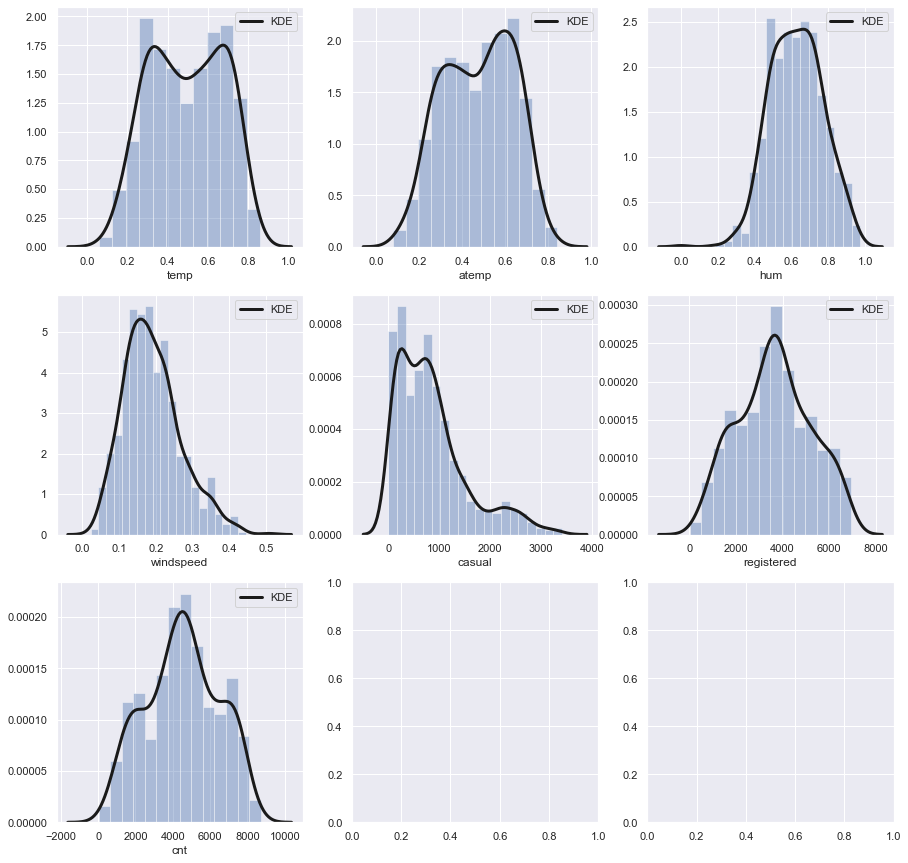

In [7]:
cont_column = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered']
fig, axs = plt.subplots(figsize=(15,15), ncols=3, nrows=3)

for i,elem in enumerate(cont_column+['cnt']):
    sns.distplot(bike_data[elem],ax=axs[i//3,i%3], rug_kws = {"color": "w"},kde_kws = {"color": "k", "lw": 3, "label": "KDE"})

#### Observations from graphs

<br>1- temp is almost normally distributed
<br>2- atemp is same as temp there might be corelation between temp and a temp
<br>3- hum is almost normally distributed with some otliers in the left side
<br>4- windspeed is  slighty right skewed with some outliers in the right side
<br>5- casual is highly right skewed implying that signifacnt amount of outliers are there in casual
<br>6- registered is again almost normally distributed
<br>7- cnt is slightly left skewed but not so significant 

### Till now the data is almost normally distributed with some outliers in windspeed and casual 

# Outlier Analysis

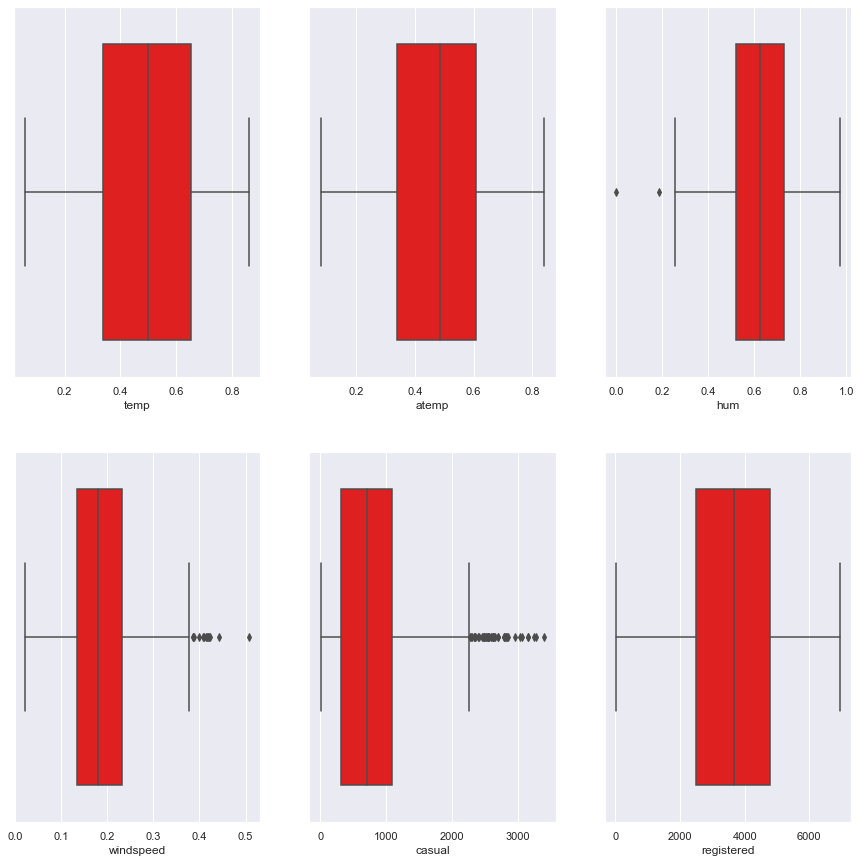

In [8]:
fig, axs = plt.subplots(figsize=(15,15), ncols=3, nrows=2)

for i,elem in enumerate(cont_column):
    sns.boxplot(bike_data[elem],ax=axs[i//3,i%3],color = 'red')

Observations from graphs
<br> 1-there are  only two outliers in the hum column
<br> 2-there are few outliers in windspeed
<br> 3- there are many outliers in caual column

### lets remove these outliers

In [9]:
cnames = ['casual','windspeed','hum']
old_data_count = len(bike_data)
for i in cnames:
    q75, q25 = np.percentile(bike_data.loc[:,i], [75 ,25])
    iqr = q75 - q25
    minline = q25 - (iqr*1.5)
    maxline = q75 + (iqr*1.5)
    
    count_outliers = len(bike_data[bike_data.loc[:,i] < minline].index)+len(bike_data[bike_data.loc[:,i] > maxline].index)
    print("outliers in "+i+" :",count_outliers)
    
    bike_data = bike_data.drop(bike_data[bike_data.loc[:,i] < minline].index)
    bike_data = bike_data.drop(bike_data[bike_data.loc[:,i] > maxline].index)
    
    
total_row_removed = (old_data_count-len(bike_data))    
data_loss_per = round((total_row_removed/old_data_count)*100,2)

print("count of data entry lost : "+str(total_row_removed))
print("data loss percentage after removing outliers : "+ str(data_loss_per)+"%" )

outliers in casual : 44
outliers in windspeed : 13
outliers in hum : 1
count of data entry lost : 58
data loss percentage after removing outliers : 7.93%


the data loss is less than 10% so i am going for removal of row instead of imputation

# Feature selection 

##### lets plot corelation plot for all numeric variable

In [10]:
numeric_column = bike_data.loc[:,cont_column+['cnt']]
numeric_column.corr().style.background_gradient(cmap=plt.get_cmap('Reds'))

,temp,atemp,hum,windspeed,casual,registered,cnt
temp,1,0.991483,0.122486,-0.139599,0.595525,0.54512,0.629031
atemp,0.991483,1,0.135356,-0.167087,0.593962,0.54785,0.630906
hum,0.122486,0.135356,1,-0.206719,-0.0963499,-0.113078,-0.122854
windspeed,-0.139599,-0.167087,-0.206719,1,-0.184026,-0.212375,-0.231596
casual,0.595525,0.593962,-0.0963499,-0.184026,1,0.427474,0.64289
registered,0.54512,0.54785,-0.113078,-0.212375,0.427474,1,0.967266
cnt,0.629031,0.630906,-0.122854,-0.231596,0.64289,0.967266,1


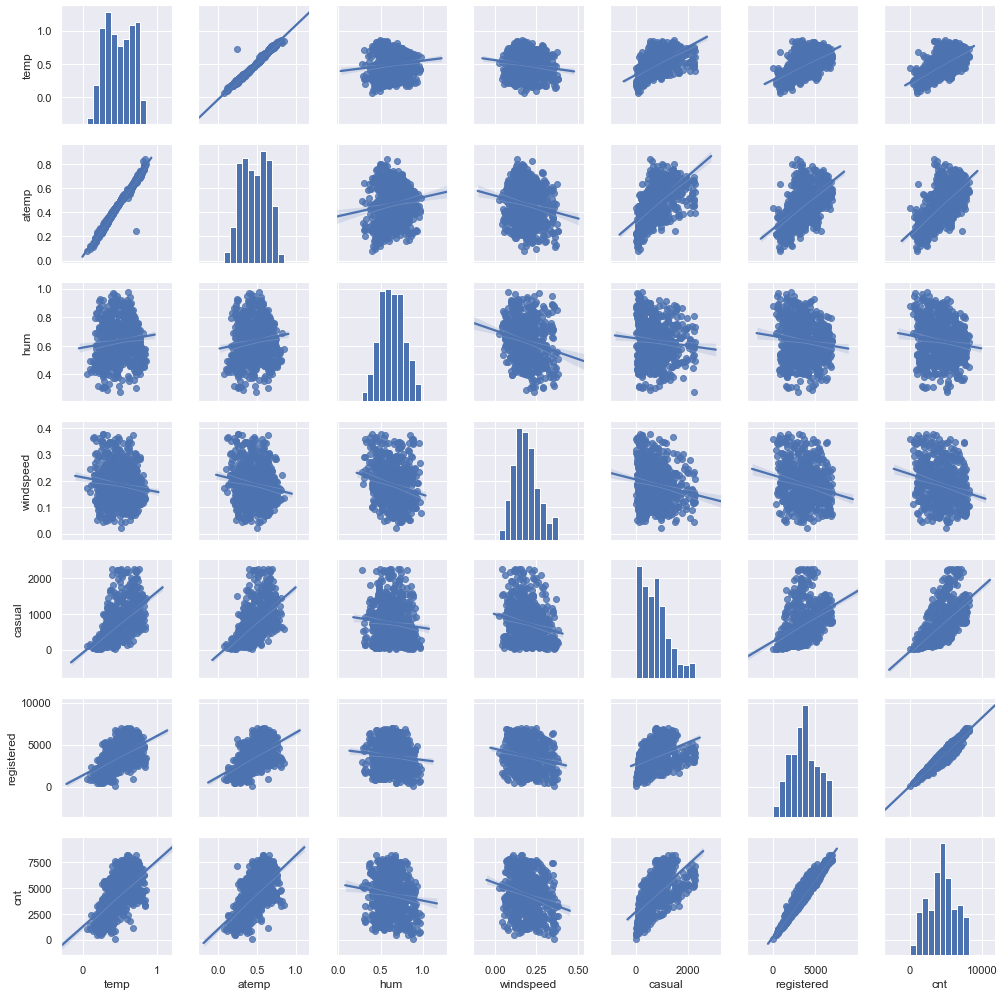

In [11]:
sns.pairplot(numeric_column, height = 2,kind="reg")
plt.show();

### Observations
<br> 1: temp and atemp is highgly corelated so we should remove atemp
<br> 2: windspeed and cnt very less related to each other so this will not give much data
<br> 3: windspeed and cnt very less related to each other so this will not give much data

## lets check what kind of realation does continuous independent variable has with dependent variable

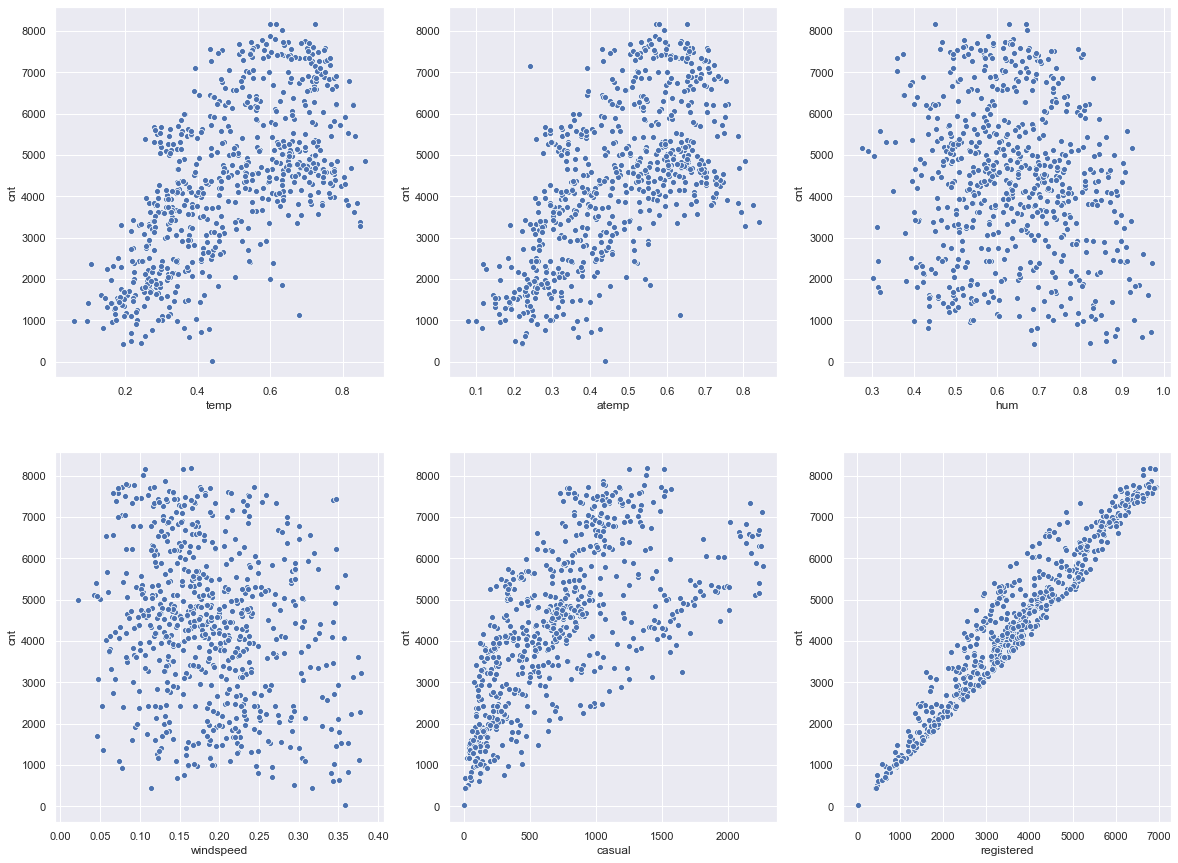

In [12]:
fig, axs = plt.subplots(figsize=(20,15), ncols=3, nrows=2)

for i,elem in enumerate(cont_column):
    sns.scatterplot(bike_data[elem],bike_data['cnt'],ax=axs[i//3,i%3]);

### observations
<br>1:temp is highly positeively related with cnt
<br>2:atemp is highly positeively related with cnt and same as temp
<br>3:hm is very loosely neagtively related with cnt
<br>4:windspeed is also  neagtively related with cnt but relation is weak
<br>5:casual is positvely related with cnt with average relation
<br>6:registered is very strongly positively related with cnt

Removing atemp,windspeed,hum from data

##  Lets have a look on tendency of categorical variables

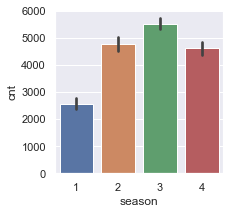

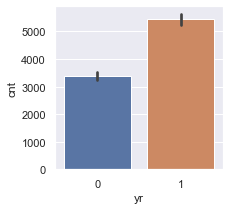

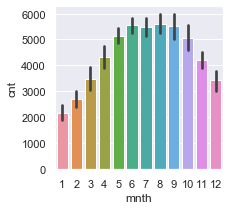

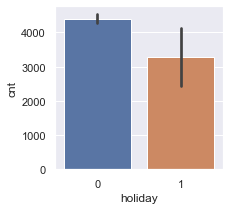

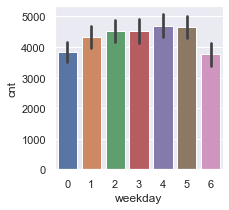

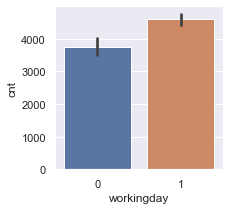

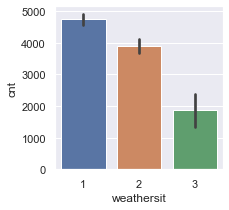

In [13]:
for i,elem in enumerate(cat_column):
    fig, ax = plt.subplots(figsize=(3,3))
    sns.barplot(data=bike_data[[elem,
                      'cnt']],
            x=elem, y='cnt')

###  Observation
#### Season
<br>1:the cnt is low for season 1
<br>2:the cnt for season 2 and 3 is almost same
<br>3:the 3 season has max no. of cnt
#### Year
<br>1: the yr 1 has more count in respect with yr 0
#### Month
<br> the count is less in starting months and increases in the middle of the year and then again decreases 
#### Holiday
<br> if it is a holiday the cnt is less 
#### Weekday
<br> the cnt is less on weekends and somewhat equivalent on the weekdays with slight variation so we should remove it
#### Working day
<br> if it is a working day the cnt is more 
#### Weather situation
<br> the most cnt is for weather 1 then 2 and 3 has least cnt  


### we can remove weekday variable also because its not affecting cnt that much

In [14]:
bike_data =bike_data.drop(['atemp','hum','weekday'], axis = 1)
bike_data.head(1)

,season,yr,mnth,holiday,workingday,weathersit,temp,windspeed,casual,registered,cnt
0,1,0,1,0,0,2,0.344167,0.160446,331,654,985


# Feature scaling 

### only two variable casual and registered need to be scaled

In [15]:
cnames = ['casual','registered']

for i in cnames:
    bike_data[i] = (bike_data[i] - bike_data[i].min())/(bike_data[i].max() - bike_data[i].min())
bike_data.head(5)

,season,yr,mnth,holiday,workingday,weathersit,temp,windspeed,casual,registered,cnt
0,1,0,1,0,0,2,0.344167,0.160446,0.145833,0.091539,985
1,1,0,1,0,0,2,0.363478,0.248539,0.057181,0.093849,801
2,1,0,1,0,1,1,0.196364,0.248309,0.052305,0.174560,1349
3,1,0,1,0,1,1,0.200000,0.160296,0.046986,0.207046,1562
4,1,0,1,0,1,1,0.226957,0.186900,0.035461,0.216286,1600


# Model Creation

with our analysis we can see that linear model is most probable fit for this dataset so we will try that first but before that lets make sum analytical function to check the performance of our model


In [16]:
#Calculate MAPE
def FNMAPE(y_true, y_pred): 
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    print("MAPE value:",mape)
    return mape

In [17]:
def error_paramerter(y_test,y_predict):
    rss = ((y_predict-y_test)**2).sum()
    print("residual square sum :",rss)
    mse = np.mean((y_test-y_predict)**2)
    print("Mean Square : ",mse)
    rmse=np.sqrt(mse)
    print("Root Mean Square : ",rmse)
    return rss,mse,rmse

## Loading library for model

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lr
from sklearn.tree import DecisionTreeRegressor as dtr
from sklearn.ensemble import RandomForestRegressor as rfr

breaking data into train and test

In [19]:
X = bike_data.values[:, 0:10]
Y = bike_data.values[:,10]
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.2)

## Linear Reg Model

In [20]:
LRmodel = lr().fit(X_train,y_train)
LRpredict = LRmodel.predict(X_test)
FNMAPE(y_test,LRpredict)
error_paramerter(y_test,LRpredict)

MAPE value: 7.130134198756654e-14
residual square sum : 1.4249349273962304e-21
Mean Square :  1.0555073536268373e-23
Root Mean Square :  3.248857266219674e-12


(1.4249349273962304e-21, 1.0555073536268373e-23, 3.248857266219674e-12)

In [21]:
LRmodel.coef_

array([ 0.00000000e+00, -1.30739863e-12, -4.54747351e-13,  1.01371689e-12,
        2.32436292e-12,  1.27453603e-13, -7.90478794e-14,  1.61226588e-12,
        2.25600000e+03,  6.92600000e+03])

## Observation
MAPE value:  2.0692697398395713e-13
<br>residual square sum : 4.425403567031793e-21
<br>Mean Square :  3.278076716319847e-23
<br>Root Mean Square :  5.7254490796092554e-12

## Decission Tree

In [22]:
Reg_Tree0 = dtr(max_depth=10, min_samples_split = 2 )
Reg_Tree0 = Reg_Tree0.fit(X_train, y_train)
predictions_DT0 = Reg_Tree0.predict(X_test)
FNMAPE(y_test,predictions_DT0)
error_paramerter(y_test,predictions_DT0)

MAPE value: 3.775393716830249
residual square sum : 4505429.410028121
Mean Square :  33373.551185393495
Root Mean Square :  182.68429375672528


(4505429.410028121, 33373.551185393495, 182.68429375672528)

i have checked for different depth this is config is giving the best result

## Observation
MAPE value: 20.256473661545463
<br>residual square sum : 5364810.738282313
<br>Mean Square :  39739.3388020912
<br>Root Mean Square :  199.34728190294243

## Random Forrest

In [23]:
RF_model = rfr(n_estimators= 50, random_state=100).fit(X_train,y_train)
RF_predict= RF_model.predict(X_test)
FNMAPE(y_test,RF_predict)
error_paramerter(y_test,RF_predict)

MAPE value: 2.4734276608230226
residual square sum : 1763373.919199999
Mean Square :  13062.029031111104
Root Mean Square :  114.28923409976595


(1763373.919199999, 13062.029031111104, 114.28923409976595)

## Observation 
MAPE value: 21.306310345968075
<br>residual square sum : 1257282.5076000008
<br>Mean Square :  9313.203760000006
<br>Root Mean Square :  96.50494163513082

#  from the results from all the model it is quite clear that the Linear reg model is best fitted for this dataset

In [24]:
data = X_test
columns = list(bike_data.columns)
columns.remove('cnt')
output_data= pd.DataFrame(data[0:,0:],columns=columns)
output_data['cnt'] = y_test
output_data['p_cnt_lr'] = LRpredict
output_data['p_cnt_dt'] = predictions_DT0
output_data['p_cnt_rf'] = RF_predict


In [25]:
output_data

,season,yr,mnth,holiday,workingday,weathersit,temp,windspeed,casual,registered,cnt,p_cnt_lr,p_cnt_dt,p_cnt_rf
0,4,1,11,0,1,1,0.28087,0.115522,0.106826,0.73058,5323,5323.0,5375.000000,5392.68
1,1,0,3,0,0,1,0.384348,0.270604,0.434397,0.204303,2417,2417.0,2496.000000,2395.76
2,1,0,1,0,1,1,0.195,0.113837,0.00576241,0.0571759,431,431.0,506.000000,586.40
3,1,1,1,0,1,2,0.373043,0.34913,0.0554078,0.402541,2935,2935.0,2933.000000,3064.86
4,1,0,1,0,0,1,0.0591304,0.17197,0.0403369,0.125325,981,981.0,986.000000,981.80
5,2,1,4,0,1,1,0.466667,0.100133,0.596631,0.780248,6772,6772.0,6871.000000,6593.00
6,3,1,7,0,0,1,0.8225,0.125629,0.532358,0.497979,4672,4672.0,4509.666667,4641.64
7,4,1,11,0,0,1,0.325833,0.179108,0.531472,0.561074,5107,5107.0,5127.500000,5003.26
8,4,1,11,0,1,1,0.313333,0.04665,0.148493,0.682934,5087,5087.0,5170.000000,5135.50
9,4,0,10,0,0,1,0.521667,0.0454042,0.989805,0.455386,5409,5409.0,5169.000000,5114.00


In [26]:
output_data.to_csv("output_of_test_data.csv")